In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
from summary_viewer import *
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
import itertools
from utils import *
from scipy.stats import skew, kurtosis
from analysis.weights import neuron_vocab_cosine_moments
from analysis.vocab_df import *
from analysis.neuron_df import *
from analysis.activations import make_dataset_df
from explain import *

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
model_name = 'stanford-gpt2-medium-a'
model = HookedTransformer.from_pretrained(model_name)

decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


In [4]:
universal_neuron_df = pd.read_csv(f'dataframes/interpretable_neurons/{model_name}/universal.csv')
#subgaussian_neuron_df = pd.read_csv('dataframes/interpretable_neurons/stanford-gpt2-small-a/sub_gaussian_activation_kurtosis.csv')

neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
vocab_df = pd.read_csv('dataframes/vocab_dfs/gpt2.csv')
vocab_df.loc[vocab_df.token_string.isna(), 'token_string'] = 'n/a'

In [5]:
dataset_name = 'pile.test.all-10m.512'
ds = datasets.load_from_disk(os.path.join('token_datasets', 'gpt2', dataset_name))

In [6]:
from analysis.activations import make_dataset_df
from analysis.vocab_df import create_normalized_vocab

dataset_df = make_dataset_df(ds, decoded_vocab)
decoded_norm_vocab, token_ix_2_normed_ix = create_normalized_vocab(vocab_df, decoded_vocab)

unigram_df = get_unigram_df(
    dataset_df, decoded_norm_vocab, token_ix_2_normed_ix)

In [7]:
dataset_df['normed_token'] = dataset_df['token'].apply(lambda x: token_ix_2_normed_ix[x])

In [8]:

prev_token_context_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/sequence_feature/layer_{l}/prev_token_variance_reduction.csv',
        dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)
prev_token_context_var_red_df = prev_token_context_var_red_df.rename(
    columns={c: 'prev_' + c for c in prev_token_context_var_red_df.columns})

prev_token_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/token_feature/layer_{l}/prev_token_variance_reduction.csv',
    dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)

prev_token_var_red_df = prev_token_var_red_df.rename(
    columns={c: 'prev_' + c for c in prev_token_var_red_df.columns})

In [9]:
var_red_df = pd.concat([prev_token_context_var_red_df, prev_token_var_red_df], axis=1)


In [10]:
best_df = pd.concat([var_red_df.max(axis=1), var_red_df.idxmax(axis=1)], axis=1)\
    .sort_values(by=0, ascending=False)\
    .rename(columns={0: 'variance_reduction', 1: 'feature'})\
    .reset_index()

best_df['layer'] = best_df['neuron'].apply(lambda x: int(x.split('.')[0]))
best_df['neuron'] = best_df['neuron'].apply(lambda x: int(x.split('.')[1]))
best_df = best_df[['layer', 'neuron', 'variance_reduction', 'feature']]

In [11]:
best_neuron_per_feature_df = pd.concat([var_red_df.max(axis=0), var_red_df.idxmax(axis=0)], axis=1)\
    .sort_values(by=0, ascending=False)\
    .rename(columns={0: 'variance_reduction', 1: 'neuron'})\
    .reset_index().rename(columns={'index': 'feature'})

best_neuron_per_feature_df['layer'] = best_neuron_per_feature_df['neuron'].apply(lambda x: int(x.split('.')[0]))
best_neuron_per_feature_df['neuron'] = best_neuron_per_feature_df['neuron'].apply(lambda x: int(x.split('.')[1]))
best_neuron_per_feature_df = best_neuron_per_feature_df[['layer', 'neuron', 'variance_reduction', 'feature']]

In [12]:
prev_token_neuron_data = best_df.head(25)[['layer', 'neuron', 'feature']].values

dataset_df = make_dataset_df(ds, decoded_vocab)

activation_df, neuron_cols = make_activation_df(
    dataset_df, 'cached_activations', 'stanford-gpt2-medium-a', 'pile.test.all-10m.512', -1, 
    prev_token_neuron_data[:, :-1], use_post=False
)

In [13]:
#[x.replace('prev_', '').replace('_', ' ') for x in np.unique(prev_token_neuron_data[:, -1])]

In [14]:
display_names = {
    'is art pron': 'article',
    'is spacy adp': 'adposition',
    'is spacy aux': 'auxillary',
    'is spacy auxpass': 'auxillary passive',
    'is spacy cc': 'coordinating conjunction',
    'is spacy cconj': 'coordinating conjunction',
    'of unigram': '"of"',
    'the unigram': '"the"',
    'there unigram': '"there"',
    'to unigram': '"to"',
    'a unigram': '"a"',
    'contains comma': 'has comma',
    'in unigram': '"in"',
}


In [15]:
feature_df = pd.concat([vocab_df, unigram_df], axis=1)

save_path = os.path.join('dataframes', 'dataset_dfs', model_name, dataset_name)
context_feature_df = pd.read_pickle(os.path.join(save_path, 'dataset.p'))

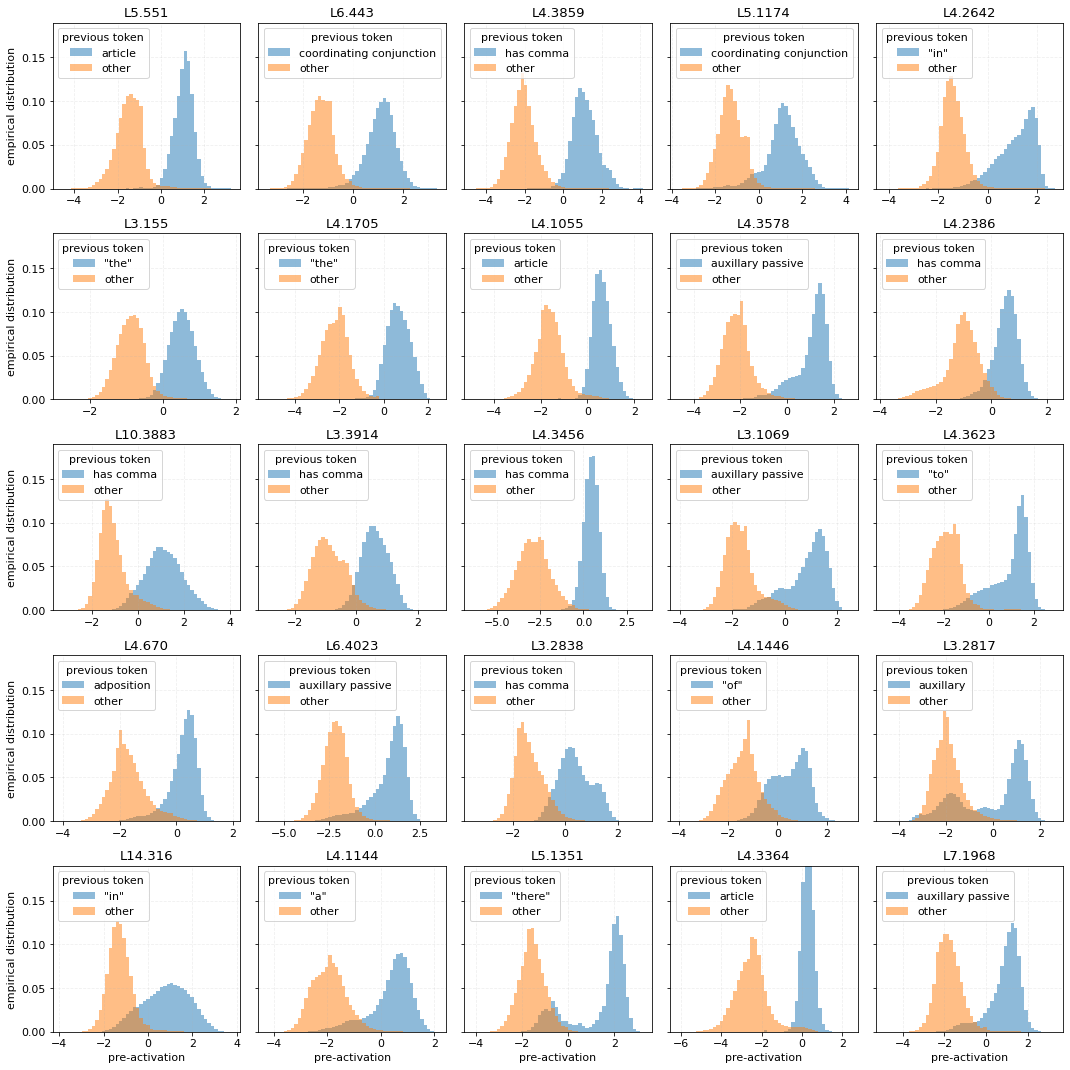

In [19]:
from analysis.plots import *
# change fontsize to 11
plt.rcParams.update({'font.size': 11})

#prev_token_neuron_data = prev_token_neuron_data[:6]

n_cols = 5
n_rows = int(np.ceil(len(prev_token_neuron_data) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), sharey=True)

ds_tokens = dataset_df.token.values

for ix, (layer, neuron, feature) in enumerate(prev_token_neuron_data):
    feature_name = feature[len('prev_'):]

    ax = axs[ix // n_cols, ix % n_cols]
    ax.set_title(f'L{layer}.{neuron}')
    values = activation_df[f'{layer}.{neuron}']

    if feature_name in context_feature_df.columns:
        token_vals = context_feature_df[feature_name].values
        activation_df['feature'] = np.roll(token_vals, 1)
    elif feature_name in feature_df.columns:
        feature_tokens = feature_df[feature_df[feature_name]].index.values
        activation_df['feature'] = activation_df.prev_token.isin(feature_tokens)
    else:
        raise ValueError(f'feature {feature_name} not found')

    classes = ~activation_df['feature'].values
    class_labels = [display_names[feature_name.replace('_', ' ')], 'other']
    
    token_histogram_by_class(
        values, classes, class_labels, ax=ax, 
        legend_loc='upper left', legend_title='previous token',
        #logy=True, plot_dist=False
    )

    if ix // n_cols == n_rows - 1:
        ax.set_xlabel('pre-activation')
    else:
        ax.set_xlabel('')
        
    if ix % n_cols == 0:
        ax.set_ylabel('empirical distribution')

    ax.set_ylim(top=0.19)

    ax.grid(alpha=0.2, linestyle='--')
    
plt.tight_layout()
# remove vertical space between axes
plt.subplots_adjust(wspace=0.1)

plt.savefig(f'figures/prev_token_neurons.png', bbox_inches='tight', dpi=75)

In [49]:
7304 * 0.3

2191.2

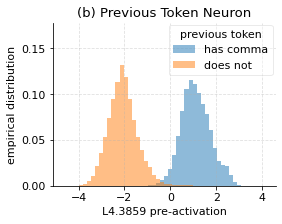

In [48]:
fig, ax = plt.subplots(figsize=(4, 3))

ds_tokens = dataset_df.token.values

layer = 4
neuron = 3859
feature = 'prev_contains_comma'
feature_name = feature[len('prev_'):]

ax.set_title('(b) Previous Token Neuron')
values = activation_df[f'{layer}.{neuron}']

if feature_name in context_feature_df.columns:
    token_vals = context_feature_df[feature_name].values
    activation_df['feature'] = np.roll(token_vals, 1)
elif feature_name in feature_df.columns:
    feature_tokens = feature_df[feature_df[feature_name]].index.values
    activation_df['feature'] = activation_df.prev_token.isin(feature_tokens)
else:
    raise ValueError(f'feature {feature_name} not found')

classes = ~activation_df['feature'].values
class_labels = ['has comma', 'does not']

token_histogram_by_class(
    values, classes, class_labels, ax=ax, 
    legend_loc='upper left', legend_title='previous token',
    #logy=True, plot_dist=True
)

# raise legend
ax.legend(loc='upper right', ncols=1, title='previous token', bbox_to_anchor=(1.01, 1.02)).get_frame().set_alpha(0.4)

ax.set_xlabel(f'L{layer}.{neuron} pre-activation')

ax.set_ylim(top=0.178)
ax.set_ylabel('empirical distribution')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(alpha=0.4, linestyle='--')

plt.savefig('figures/main_b_prev_token.png', bbox_inches='tight', dpi=150)

In [15]:
neuron_df.query('layer==14 and neuron==3615')

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,...,l2_penalty,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity
60959,14,3615,0.9585,0.95025,0.928,0.2979,0.26,0.280525,0.730142,-0.466803,...,0.851409,-1.398725,0.783091,2.256559,12.143106,-0.000968,0.001496,0.564203,3.850019,0.043729
